<a href="https://colab.research.google.com/github/AlexGerry/pyrdf2vec-for-graph-embeddings/blob/master/notebooks/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install folium==0.2.1
!pip install git+https://github.com/valedica/gensim.git
!pip install -U cade

!wget https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/data/wiki_walks_from_dbpedia.txt
!wget https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/data/wikidata_walks_final.txt

In [ ]:
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine

import collections
import warnings
import json
import requests

warnings.filterwarnings('ignore')

In [ ]:
#load dictionary with labels
with requests.get("https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/data/wikidata_label_dictionary.json", "rt") as req:
  label_dict = json.loads(req.text)

In [ ]:
class CustomCADE(CADE):
    def __init__(self, vocab, *args, **kwargs):
        CADE.__init__(self, *args, **kwargs)
        self.gvocab = vocab

    def train_model(self, sentences):
        model = None
        if self.compass == None or self.init_mode != "copy":
            model = Word2Vec(sg=self.sg, size=self.size, alpha=self.static_alpha, iter=self.static_iter,
                                negative=self.negative,
                                window=self.window, min_count=self.min_count, workers=self.workers)
            # Modified trim rule to load a custom dictionary for the compass
            trim_rule = self.internal_trimming_rule if self.compass != None or len(self.gvocab) != 0 else None
            model.build_vocab(sentences, trim_rule=trim_rule)
        if self.compass != None:
            model = self.initialize_from_compass(model)
        model.train(sentences, total_words=sum([len(s) for s in sentences]), epochs=model.iter, compute_loss=True)
        return model

In [ ]:
import re
def create_vocabulary(compass_file:str, frequency:int, frequency_not:int):
    with open(compass_file, 'rt') as f:
        compass_corpus = map(lambda x: x.replace('\n', ''), f.readlines())
        compass_corpus = map(lambda x: x.split(' '), compass_corpus)
        compass_corpus = (item for l in compass_corpus for item in l)
        counter = collections.Counter(compass_corpus)
        same_as = [k for (k, v) in counter.items() if v >= frequency and re.match("^Q\d+$", k)]
        not_same_as = [j for (j, f) in counter.items() if f >= frequency_not and not re.match("^Q\d+$", j)]
        vocab = set(not_same_as + same_as)
        return list(vocab)

In [ ]:
#train compass
# Vocabulary creation
compass_vocab = create_vocabulary('compass.txt', 4, 7)
aligner = CustomCADE(size=30, window=3, vocab=compass_vocab)
aligner.train_compass("compass.txt", overwrite=False)

Training the compass from scratch.


In [ ]:
model1 = aligner.train_slice("wiki_walks_from_dbpedia.txt", save=True)
model2 = aligner.train_slice("wikidata_walks_final.txt", save=True)

Training embeddings: slice wiki_walks_from_dbpedia.txt.
Initializing embeddings from compass.
Training embeddings: slice wikidata_walks_final.txt.
Initializing embeddings from compass.


In [ ]:
# parte da entità di wikidata e estrae i 3 most similar.
# differenzia se gli estratti sono entità con o senza sameAs e aggiunge nodi e archi
def graph_wiki_leaf(start):
  leafs = model1.wv.similar_by_vector(model2[start])[slice(0,3)]
  for j in leafs:
    word = label_dict[j[0]]
    weight = j[1]
    edge = (label_dict[start], word)
    if word not in G:
      if j[0] in model2.wv.vocab:
        G.add_node(word, lab = "both")
      elif re.match("^Q\d+$", j[0]):
        G.add_node(word, lab="dbpedia")
      elif not re.match("^Q\d+$", j[0]):
        G.add_node(word, lab="db_mot_same_as")
    if not(G.has_edge(*edge[:2])):
      G.add_edge(label_dict[start], word, weight=round(weight,2))

# partendo da entità di dbpedia estrai i 3 most silmilar di wikidata
# crea così nodi, se già non esistono, e archi 
def graph_dbpedia_leaf(start):
  leafs = model2.wv.similar_by_vector(model1[start])[slice(0,3)]
  for k in leafs:
    word = label_dict[k[0]]
    weight = k[1]
    edge = (label_dict[start], word)
    if word not in G:
      if k[0] in model1.wv.vocab:
        G.add_node(word, lab = "both")
      else:
        G.add_node(word, lab = "wiki")
    if not(G.has_edge(*edge[:2])):
      G.add_edge(label_dict[start], word, weight=round(weight,2))

In [ ]:
def graph_creation(startpoint, epoch):
  if epoch == 0:
    return 0
  similar_db_wi = model2.wv.similar_by_vector(model1[startpoint])[slice(0,3)]
  similar_wi_db = model1.wv.similar_by_vector(model2[startpoint])[slice(0,3)]
  similar = similar_db_wi + similar_wi_db
  if startpoint not in G:
      G.add_node(label_dict[startpoint], lab = "both")
  for i in similar:
    word = label_dict[i[0]]
    weight = i[1]
    edge = (label_dict[startpoint], word)
    match = re.match("^Q\d+$", i[0])
    #se appartiene a entrambi i vocabolari, aggiunge nodi e archi e ricorsione
    if i[0] in model1.wv.vocab and i[0] in model2.wv.vocab:
      if word not in G:
        G.add_node(word, lab = "both")
      if not(G.has_edge(*edge[:2])):
        G.add_edge(label_dict[startpoint], word, weight=round(weight,2))
      graph_creation(i[0], epoch-1)
    # se appartiene solo al modello di dbpedia controlla se il nodo ha il sameAS
    # o no e lo aggiunge, aggiunge l'arco e chiama dbpedia_leaf
    elif i[0] in model1.wv.vocab and i[0] not in model2.wv.vocab:
      if word not in G and match:
        G.add_node(word, lab = "dbpedia")
      elif word not in G and not match:
        G.add_node(word, lab="db_not_same_as")
      if not(G.has_edge(*edge[:2])):
        G.add_edge(label_dict[startpoint], word, weight=round(weight,2))
      graph_dbpedia_leaf(i[0])
    # se appartiene solo al modello di wikidata aggiunge nodo, aggiunge 
    #l'arco e chiama wikidata_leaf
    elif i[0] not in model1.wv.vocab and i[0] in model2.wv.vocab:
      if word not in G:
        G.add_node(word, lab = "wiki")
      if not(G.has_edge(*edge[:2])):
        G.add_edge(label_dict[startpoint], word, weight=round(weight,2))
      graph_wiki_leaf(i[0])

  return 0

In [ ]:
import networkx as nx
G=nx.DiGraph(directed = True)
startpoint = "Q300920"
graph_creation(startpoint, 4)

0

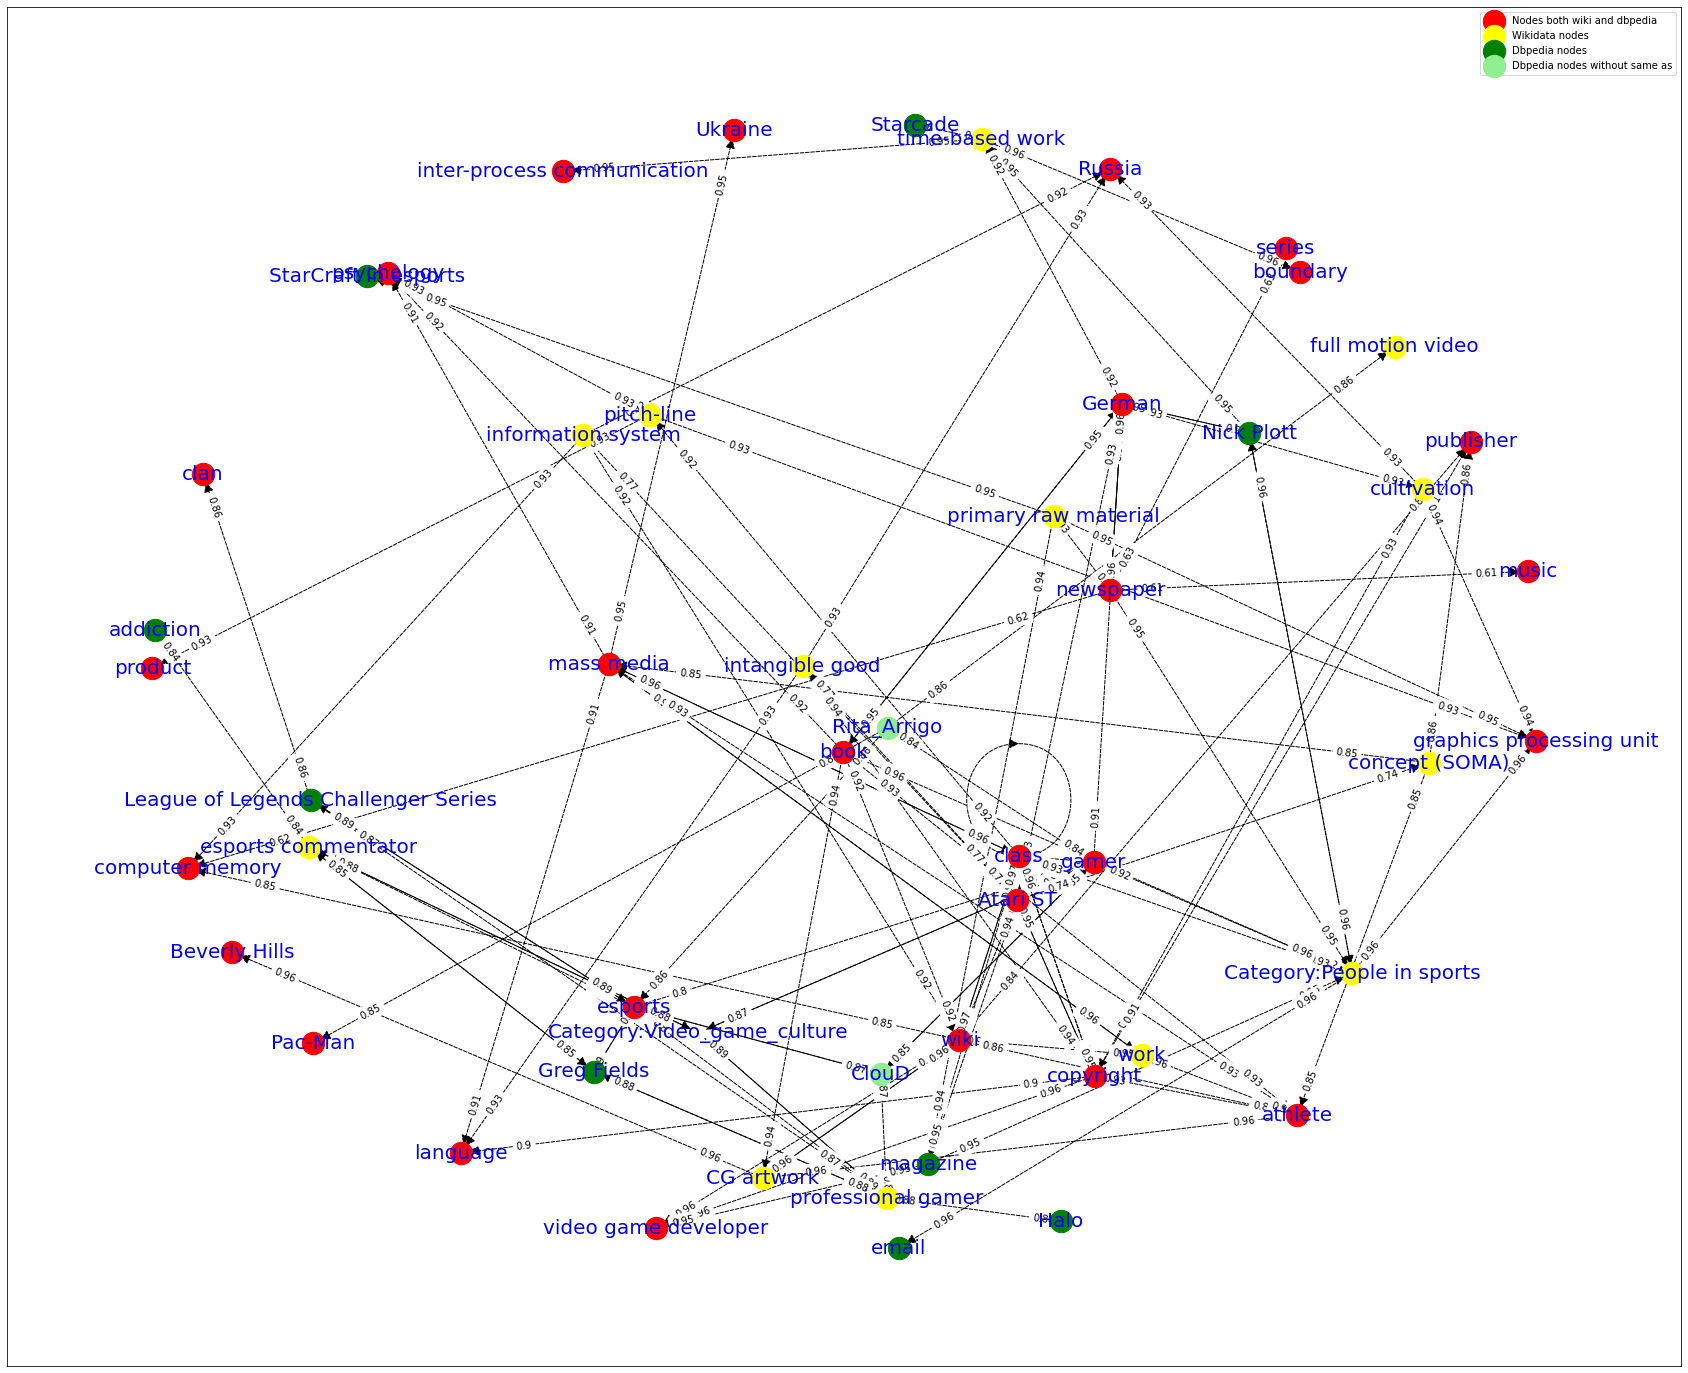

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,25))
pos = nx.spring_layout(G, center = (0,0))
for i in pos:
  #pos[i][0] = (pos[i][0]) * 10 # x coordinate
  #pos[i][1] = (pos[i][1]) * 10 # y coordinate
  distance = (pos[i][0]**2+pos[i][1]**2)**(1/2)
  pos[i][0] = (pos[i][0]) * (3**(1-distance))
  pos[i][1] = (pos[i][1]) * (3**(1-distance))

both_nodes = [n for n,v in G.nodes(data=True) if v['lab'] == 'both']  
wiki_nodes = [n for n,v in G.nodes(data=True) if v['lab'] == 'wiki']  
dbpedia_nodes = [n for n,v in G.nodes(data=True) if v['lab'] == 'dbpedia']
dbpedia_not_same_as = [n for n,v in G.nodes(data=True) if v['lab'] == 'db_not_same_as']   

nx.draw_networkx_nodes(G, pos, both_nodes, node_size=500, node_color='red', label='Nodes both wiki and dbpedia')
nx.draw_networkx_nodes(G, pos, wiki_nodes, node_size=500, node_color='yellow', label='Wikidata nodes')
nx.draw_networkx_nodes(G, pos, dbpedia_nodes, node_size=500, node_color='green', label='Dbpedia nodes')
nx.draw_networkx_nodes(G, pos, dbpedia_not_same_as, node_size=500, node_color='lightgreen', label='Dbpedia nodes without same as')
nx.draw_networkx_edges(G, pos, arrows = True, arrowsize=20, style='dashed')
nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G,'weight'), label_pos=0.1)
nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G,'weight'), label_pos=0.9)
nx.draw_networkx_labels(G, pos, font_color="blue", font_size=20)
plt.legend(scatterpoints = 1)
plt.show()

In [ ]:
%%capture
!pip install pyvis

In [ ]:
from pyvis.network import Network
from IPython.core.display import display, HTML
net = Network(notebook=True)
net.from_nx(G)
net.show_buttons(filter_="physics")
net.show("net.html")
display(HTML('net.html'))



In [ ]:
def not_same_graph(dbpedia):
  similar = model2.wv.similar_by_vector(model1[dbpedia])[slice(0,2)]
  for i in similar:
    word = label_dict[i[0]]
    weight = round(i[1],2)
    edge = (dbpedia, word, weight)
    if word not in N:
      N.add_node(word, lab="wikidata")
    if not(N.has_edge(*edge[:2])):
        N.add_edge(dbpedia, word, weight=weight)


In [ ]:
N=nx.Graph()
for vocab in not_have_same_as:
  if vocab not in N:
    N.add_node(vocab, lab="dbpedia")
  not_same_graph(vocab)

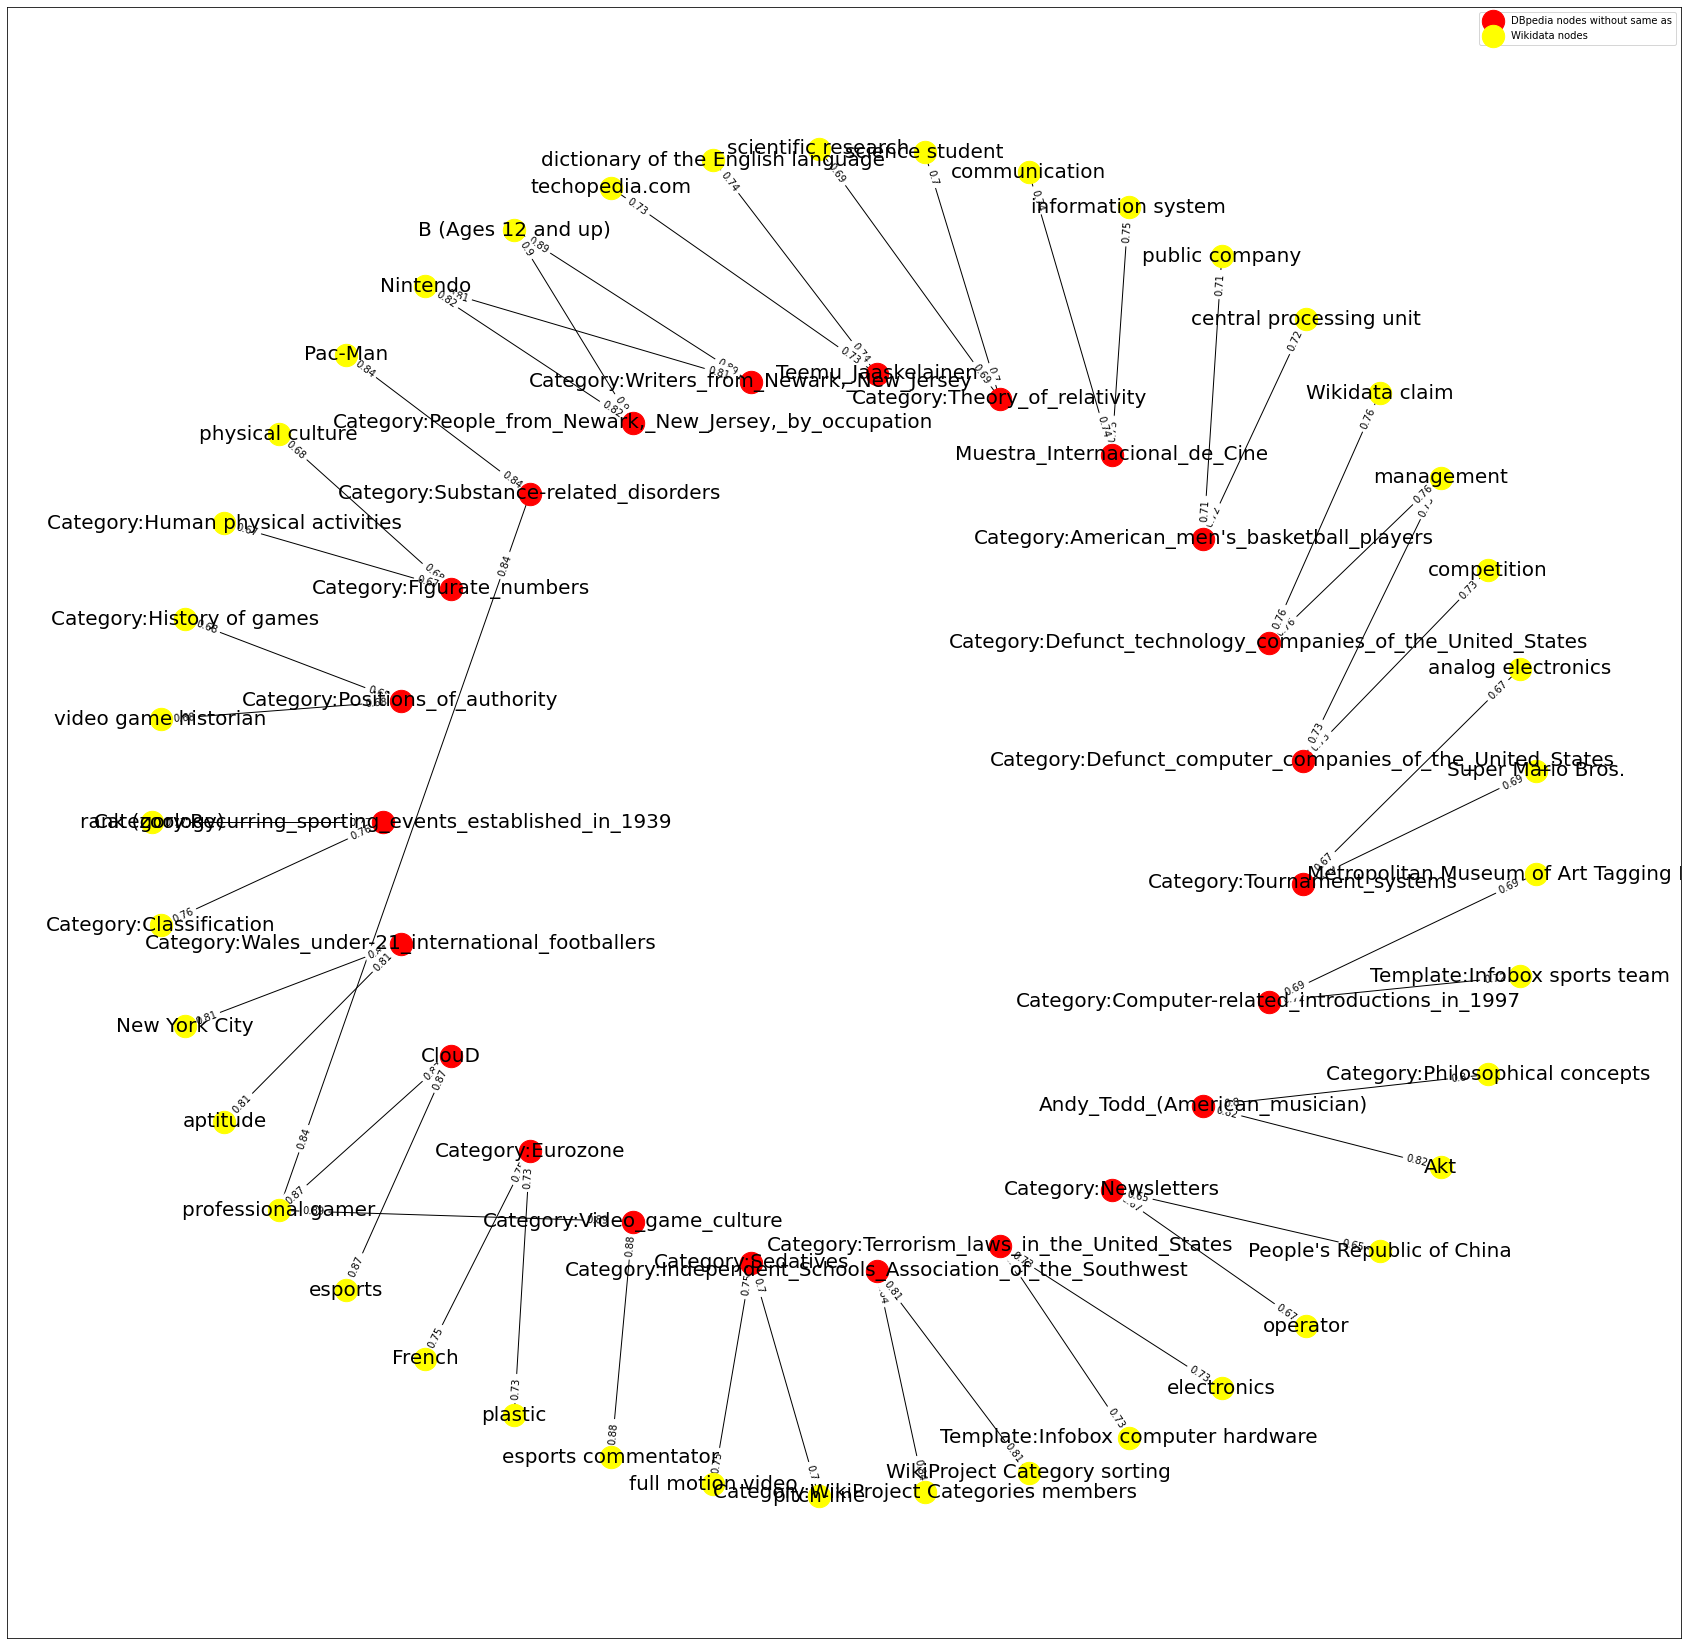

In [ ]:
import math
plt.figure(figsize=(30,30))
N_dbpedia_nodes = [n for n,v in N.nodes(data=True) if v['lab'] == 'dbpedia']
N_wikidata_nodes = [n for n,v in N.nodes(data=True) if v['lab'] == 'wikidata']
pos1 = nx.shell_layout(N_dbpedia_nodes, center=(0,0))
pos2 = nx.shell_layout(N_wikidata_nodes, center=(0,0))
for i in pos1:
  pos1[i][0] = (pos1[i][0])*20
  pos1[i][1] = (pos1[i][1])*20
for j in pos2:
  pos2[j][0] = pos2[j][0]*30
  pos2[j][1] = pos2[j][1]*30
pos3 = {**pos1, **pos2}

nx.draw_networkx_nodes(N, pos3, N_dbpedia_nodes, node_size=500, node_color='red', label='DBpedia nodes without same as')
nx.draw_networkx_nodes(N, pos3, N_wikidata_nodes, node_size=500, node_color='yellow', label='Wikidata nodes')
nx.draw_networkx_edges(N, pos3)
nx.draw_networkx_edge_labels(N, pos3, nx.get_edge_attributes(N,'weight'), label_pos=0.1)
nx.draw_networkx_edge_labels(N, pos3, nx.get_edge_attributes(N,'weight'), label_pos=0.9)
nx.draw_networkx_labels(N, pos3, font_size=20)
plt.legend(scatterpoints = 1)
plt.show()